In [8]:
# =====================================================
# PROCESAMIENTO LOCAL - BRAIN MRI (SIN GOOGLE DRIVE)
# =====================================================
import os, shutil, random, zipfile
from pathlib import Path
import time
import cv2, math, numpy as np, matplotlib.pyplot as plt, pandas as pd
from tqdm import tqdm
import torch, torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix

In [2]:
# =====================================================
# CONFIGURACIÓN DE RUTAS
# =====================================================
BASE = Path("/home/valentino/percepcion")
WORK = BASE / "nuevo"
WORK.mkdir(parents=True, exist_ok=True)

RAW_ZIP = BASE / "brain_tumor_dataset.zip"
DATA_RAW = WORK / "brain_tumor_dataset"
DATA_SPLIT = WORK / "brain_tumor_split"
DATA_FILTERED = WORK / "brain_tumor_split_filtered"
CKPT_DIR = WORK / "checkpoints"
CKPT_DIR.mkdir(exist_ok=True)

In [3]:
# =====================================================
# DESCOMPRIMIR DATASET
# =====================================================
if not DATA_RAW.exists():
    print("📦 Extrayendo brain_tumor_dataset.zip...")
    with zipfile.ZipFile(RAW_ZIP, "r") as zip_ref:
        zip_ref.extractall(DATA_RAW)
    print("✅ Dataset extraído en:", DATA_RAW)
else:
    print("✅ Dataset ya descomprimido:", DATA_RAW)


📦 Extrayendo brain_tumor_dataset.zip...
✅ Dataset extraído en: /home/valentino/percepcion/nuevo/brain_tumor_dataset


In [4]:
# =====================================================
# ORGANIZAR DATASET (train / val / test)
# =====================================================
print("\n📂 Organizando dataset...")
for split in ['train', 'val', 'test']:
    for cls in ['yes', 'no']:
        (DATA_SPLIT / split / cls).mkdir(parents=True, exist_ok=True)

# eliminar carpeta Br35H si existe
br35h = next(DATA_RAW.glob("**/Br35H*"), None)
if br35h:
    shutil.rmtree(br35h)
    print("🗑️ Carpeta Br35H eliminada.")

def split_and_copy(class_name):
    src_folder = next(DATA_RAW.glob(f"**/{class_name}"))
    imgs = [f for f in os.listdir(src_folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    random.shuffle(imgs)
    n_total = len(imgs)
    n_train = int(0.75 * n_total)
    n_val = int(0.15 * n_total)
    train_imgs = imgs[:n_train]
    val_imgs = imgs[n_train:n_train+n_val]
    test_imgs = imgs[n_train+n_val:]
    for img_set, split in [(train_imgs,'train'), (val_imgs,'val'), (test_imgs,'test')]:
        for img in img_set:
            shutil.copy2(src_folder/img, DATA_SPLIT/split/class_name/img)
    print(f"✅ {class_name}: {n_train} train, {n_val} val, {len(test_imgs)} test")

split_and_copy('yes')
split_and_copy('no')
print("✅ Dataset dividido en:", DATA_SPLIT)


📂 Organizando dataset...
✅ yes: 3167 train, 633 val, 423 test
✅ no: 3128 train, 625 val, 418 test
✅ Dataset dividido en: /home/valentino/percepcion/nuevo/brain_tumor_split


In [5]:
# =====================================================
# FILTRADO DE IMÁGENES (SIN AGREGAR RUIDO)
# =====================================================
def imread_gray(path):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    if img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return img

def psnr(img1, img2):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32))**2)
    if mse == 0:
        return 99.0
    return 20 * math.log10(255.0 / math.sqrt(mse))

filters = {
    'gaussian': lambda x: cv2.GaussianBlur(x, (5,5), 1.0),
    'median'  : lambda x: cv2.medianBlur(x, 5),
    'mean'    : lambda x: cv2.blur(x, (5,5))
}

# Evaluar PSNR solo entre filtros (sin ruido añadido)
print("\n🔎 Evaluando filtros (sin ruido artificial)...")
rows = []
for split in ['train']:
    for cls in ['yes','no']:
        files = list((DATA_SPLIT/split/cls).glob("*"))
        random.shuffle(files)
        sample_files = files[:80]
        for f in tqdm(sample_files, desc=f"{cls}"):
            img = imread_gray(f)
            if img is None:
                continue
            for name, fn in filters.items():
                den = fn(img)
                rows.append({'cls': cls, 'filter': name, 'psnr': psnr(img, den)})

df = pd.DataFrame(rows)
best_global = df.groupby('filter')['psnr'].mean().sort_values(ascending=False).index[0]
print("🏆 Mejor filtro según PSNR promedio:", best_global)

# Generar dataset filtrado
for split in ['train','val','test']:
    for cls in ['yes','no']:
        out_dir = DATA_FILTERED / split / cls
        out_dir.mkdir(parents=True, exist_ok=True)
        in_dir = DATA_SPLIT / split / cls
        for img_path in tqdm(list(in_dir.glob("*")), desc=f"Filtrando {split}/{cls}"):
            img = imread_gray(img_path)
            if img is None: continue
            den = filters[best_global](img)
            cv2.imwrite(str(out_dir / img_path.name), den)
print("\n✅ Dataset filtrado creado en:", DATA_FILTERED)


🔎 Evaluando filtros (sin ruido artificial)...


no: 100%|██████████| 80/80 [00:00<00:00, 864.65it/s]


🏆 Mejor filtro según PSNR promedio: gaussian


Filtrando test/no: 100%|██████████| 418/418 [00:00<00:00, 1033.67it/s]


✅ Dataset filtrado creado en: /home/valentino/percepcion/nuevo/brain_tumor_split_filtered


In [6]:
# =====================================================
# DATASET PARA PYTORCH
# =====================================================
class MRIDataset(Dataset):
    def __init__(self, root_dir, split, img_size=224, augment=False):
        self.root = Path(root_dir) / split
        self.paths, self.labels = [], []
        for cls, y in [('no', 0), ('yes', 1)]:
            files = sorted(list((self.root/cls).glob("*.jpg")) + 
                           list((self.root/cls).glob("*.png")))
            self.paths += files
            self.labels += [y]*len(files)
        aug_list = []
        if augment:
            aug_list += [
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10)
            ]
        self.tf = transforms.Compose([
            transforms.ToPILImage(),
            *aug_list,
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        x = self.tf(img)
        y = torch.tensor([self.labels[idx]], dtype=torch.float32)
        return x, y

In [29]:
# =====================================================
# ENTRENAMIENTO RESNET18 (ARQUITECTURA ORIGINAL + Dropout + ReLU)
# =====================================================
IMG_SIZE, BATCH = 224, 32
ds_train = MRIDataset(DATA_FILTERED, 'train', IMG_SIZE, True)
ds_val   = MRIDataset(DATA_FILTERED, 'val', IMG_SIZE, False)
ds_test  = MRIDataset(DATA_FILTERED, 'test', IMG_SIZE, False)

# Calcular pesos de clase
labels_np = np.array([int(y.item()) for _, y in [ds_train[i] for i in range(len(ds_train))]])
pos = labels_np.sum(); neg = len(labels_np) - pos
w_pos = neg / (pos + 1e-6); w_neg = pos / (neg + 1e-6)
sample_weights = np.where(labels_np==1, w_pos, w_neg)
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

dl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler)
dl_val   = DataLoader(ds_val, batch_size=BATCH)
dl_test  = DataLoader(ds_test, batch_size=BATCH)
print(f"Train: {len(ds_train)}, Val: {len(ds_val)}, Test: {len(ds_test)}")

# =====================================================
# MODELO: RESNET18 con Dropout + ReLU en la cabeza final
# =====================================================
class BrainTumorResNet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = models.resnet18(weights=weights)
        in_feats = self.backbone.fc.in_features

        # 🔹 Reemplazamos solo la cabeza final (fc) por una versión regularizada
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=0.5),       # Regulariza las features finales (reduce sobreajuste)
            nn.ReLU(inplace=True),   # Activa antes del clasificador
            nn.Linear(in_feats, 1)   # Salida binaria (logit)
        )

    def forward(self, x):
        return self.backbone(x)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = BrainTumorResNet18(pretrained=True).to(device)

# =====================================================
# CONFIGURACIÓN DE ENTRENAMIENTO
# =====================================================
pos_weight = torch.tensor([w_pos], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))

EPOCHS, EARLY_STOP = 10, 5
best_auc, patience = -1, EARLY_STOP
CKPT_PATH = CKPT_DIR / "resnet18_brain_mri_best_dropout_relu.pth"

# =====================================================
# FUNCIÓN DE EVALUACIÓN (con conversión 1→3 canales)
# =====================================================
def evaluate(model, loader):
    model.eval(); all_probs, all_true = [], []
    total_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            # 🔹 Convertir imágenes grises a RGB si es necesario
            if x.shape[1] == 1:
                x = x.repeat(1, 3, 1, 1)
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())
            all_true.append(y.cpu().numpy())
    y_true = np.vstack(all_true).ravel()
    y_prob = np.vstack(all_probs).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    pre, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = float('nan')
    cm = confusion_matrix(y_true, y_pred)
    return total_loss/len(loader.dataset), acc, pre, rec, f1, auc, cm

# =====================================================
# ENTRENAMIENTO PRINCIPAL
# =====================================================
print("\n🚀 Iniciando entrenamiento (ResNet18 con Dropout + ReLU)...")
history = []
for epoch in range(1, EPOCHS+1):
    model.train(); tr_loss=0.0; t0=time.time()
    for x, y in dl_train:
        # 🔹 Convertir a RGB si son 1 canal
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device=='cuda')):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        tr_loss += loss.item() * x.size(0)
    scheduler.step()
    tr_loss /= len(dl_train.dataset)

    # 🔹 Evaluación en validación
    val_loss, acc, pre, rec, f1, auc, cm = evaluate(model, dl_val)
    history.append({'epoch':epoch,'train_loss':tr_loss,'val_loss':val_loss,'acc':acc,'f1':f1,'auc':auc})
    print(f"Ep{epoch:02d} | loss {val_loss:.4f} | AUC {auc:.3f} | ACC {acc:.3f} | F1 {f1:.3f}")

    # 🔹 Guardado del mejor modelo
    if auc > best_auc:
        best_auc = auc; patience = EARLY_STOP
        torch.save({'model':model.state_dict(),'auc':best_auc}, CKPT_PATH)
        print(f"  🔥 Nuevo mejor modelo guardado (AUC={best_auc:.4f})")
    else:
        patience -= 1
        if patience==0:
            print("⏹️ Early stopping")
            break

# =====================================================
# TEST FINAL
# =====================================================
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt['model'])
test_loss, acc, pre, rec, f1, auc, cm = evaluate(model, dl_test)

print("\n===== RESULTADOS TEST =====")
print(f"Loss {test_loss:.4f} | ACC {acc:.3f} | PRE {pre:.3f} | REC {rec:.3f} | F1 {f1:.3f} | AUC {auc:.3f}")
print("Matriz de confusión:\n", cm)

Train: 6189, Val: 1233, Test: 824


/tmp/ipykernel_17828/1485279687.py:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))
/tmp/ipykernel_17828/1485279687.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):



🚀 Iniciando entrenamiento (ResNet18 con Dropout + ReLU)...
Ep01 | loss 0.0583 | AUC 0.996 | ACC 0.983 | F1 0.983
  🔥 Nuevo mejor modelo guardado (AUC=0.9963)


/tmp/ipykernel_17828/1485279687.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Ep02 | loss 0.0342 | AUC 0.999 | ACC 0.989 | F1 0.988
  🔥 Nuevo mejor modelo guardado (AUC=0.9988)


/tmp/ipykernel_17828/1485279687.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Ep03 | loss 0.0195 | AUC 0.999 | ACC 0.998 | F1 0.998
  🔥 Nuevo mejor modelo guardado (AUC=0.9994)


/tmp/ipykernel_17828/1485279687.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Ep04 | loss 0.0138 | AUC 1.000 | ACC 0.997 | F1 0.997
  🔥 Nuevo mejor modelo guardado (AUC=0.9998)


/tmp/ipykernel_17828/1485279687.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Ep05 | loss 0.0107 | AUC 1.000 | ACC 0.997 | F1 0.997
  🔥 Nuevo mejor modelo guardado (AUC=0.9999)


/tmp/ipykernel_17828/1485279687.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Ep06 | loss 0.0062 | AUC 1.000 | ACC 0.998 | F1 0.998
  🔥 Nuevo mejor modelo guardado (AUC=1.0000)


/tmp/ipykernel_17828/1485279687.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Ep07 | loss 0.0046 | AUC 1.000 | ACC 0.999 | F1 0.999
  🔥 Nuevo mejor modelo guardado (AUC=1.0000)


/tmp/ipykernel_17828/1485279687.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Ep08 | loss 0.0044 | AUC 1.000 | ACC 0.999 | F1 0.999


/tmp/ipykernel_17828/1485279687.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Ep09 | loss 0.0038 | AUC 1.000 | ACC 0.999 | F1 0.999


/tmp/ipykernel_17828/1485279687.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Ep10 | loss 0.0037 | AUC 1.000 | ACC 0.999 | F1 0.999

===== RESULTADOS TEST =====
Loss 0.0099 | ACC 0.996 | PRE 1.000 | REC 0.993 | F1 0.996 | AUC 1.000
Matriz de confusión:
 [[417   0]
 [  3 404]]


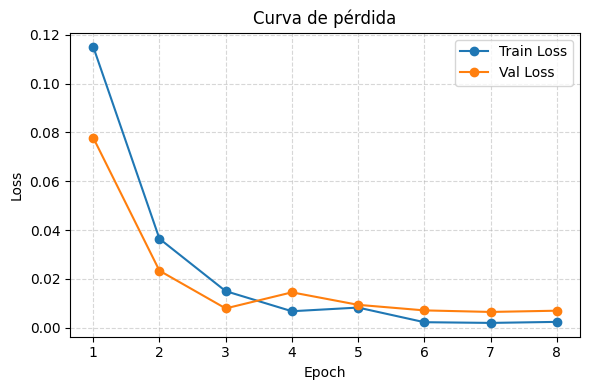

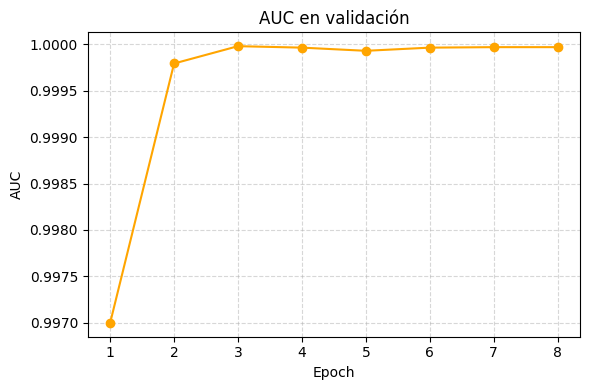

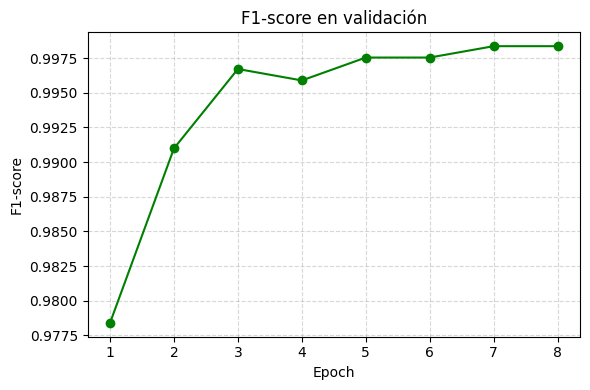

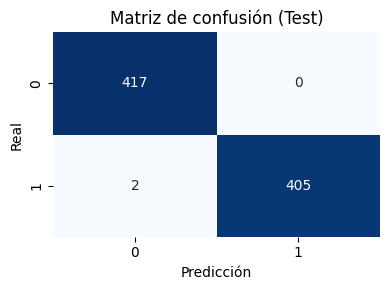

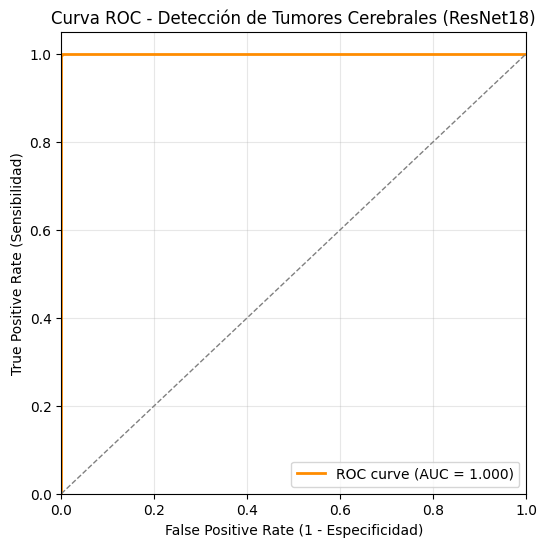

✅ AUC calculado en test: 1.000


In [48]:
# =====================================================
# 📊 VISUALIZACIÓN DE RESULTADOS Y MÉTRICAS
# =====================================================
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc as compute_auc

# Crear carpeta para gráficos
PLOTS_DIR = WORK / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------------
# 1️⃣ Curvas de pérdida (Train vs Val)
# -------------------------------
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
val_loss = [h['val_loss'] for h in history]

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, '-o', label='Train Loss')
plt.plot(epochs, val_loss, '-o', label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Curva de pérdida')
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "loss_curve.png", dpi=150)
plt.show()

# -------------------------------
# 2️⃣ Curva de AUC por época
# -------------------------------
auc_vals = [h['auc'] for h in history]

plt.figure(figsize=(6,4))
plt.plot(epochs, auc_vals, '-o', color='orange')
plt.xlabel('Epoch'); plt.ylabel('AUC')
plt.title('AUC en validación')
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "auc_curve.png", dpi=150)
plt.show()

# -------------------------------
# 3️⃣ Curva de F1-score
# -------------------------------
f1_vals = [h['f1'] for h in history]

plt.figure(figsize=(6,4))
plt.plot(epochs, f1_vals, '-o', color='green')
plt.xlabel('Epoch'); plt.ylabel('F1-score')
plt.title('F1-score en validación')
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "f1_curve.png", dpi=150)
plt.show()

# -------------------------------
# 4️⃣ Matriz de confusión en Test
# -------------------------------
import seaborn as sns

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de confusión (Test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "confusion_matrix.png", dpi=150)
plt.show()

# =====================================================
# 📈 CURVA ROC + AUC (Evaluación en TEST)
# =====================================================
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Asegúrate de haber obtenido estos valores del bloque "evaluate"
# test_loss, acc, pre, rec, f1, auc_val, cm, (y_true, y_prob, y_pred) = evaluate(...)

# Si tu evaluate no devuelve y_true y y_prob, puedes regenerarlos así:
def get_test_preds(model, loader):
    model.eval()
    y_true, y_prob = [], []
    with torch.no_grad():
        for x, y in loader:
            # Si entrenaste con imágenes grises → convertir a RGB
            if x.shape[1] == 1:
                x = x.repeat(1, 3, 1, 1)
            x = x.to(device)
            y_true.extend(y.numpy().ravel())
            y_prob.extend(torch.sigmoid(model(x)).cpu().numpy().ravel())
    return np.array(y_true), np.array(y_prob)

# Obtener predicciones reales y probabilidades del test set
y_true, y_prob = get_test_preds(model, dl_test)

# Calcular puntos ROC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# =========================
# 📊 Gráfico ROC
# =========================
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Especificidad)')
plt.ylabel('True Positive Rate (Sensibilidad)')
plt.title('Curva ROC - Detección de Tumores Cerebrales (ResNet18)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

print(f"✅ AUC calculado en test: {roc_auc:.3f}")


/tmp/ipykernel_17828/341057418.py:89: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


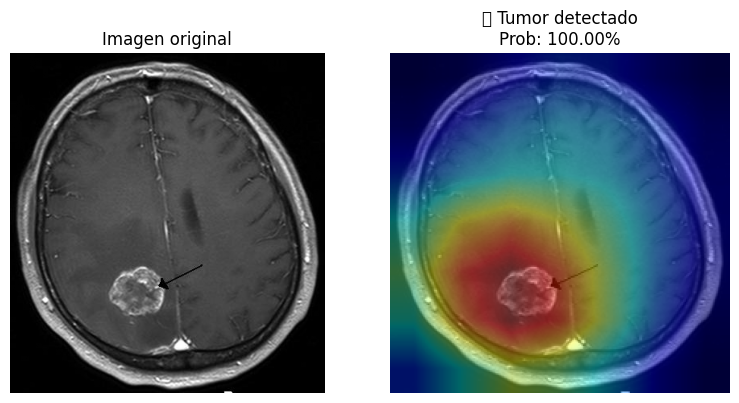


📷 Imagen: /mnt/c/Users/Valentino/Downloads/cerebrito.jpg
→ Predicción: 🧠 Tumor detectado
→ Probabilidad: 100.00%


In [47]:
# =====================================================
# 🔍 INFERENCIA + GRAD-CAM VISUALIZATION (solo original y overlay)
# =====================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torchvision.transforms as T

def gradcam_visualize(model, image_path, device, threshold=0.75):
    model.eval()

    # --- 1️⃣ Cargar y preparar imagen ---
    img_pil = Image.open(image_path).convert("L")
    img_np = np.array(img_pil)

    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.5], std=[0.5])
    ])
    x = transform(img_np).unsqueeze(0).repeat(1, 3, 1, 1).to(device)

    # --- 2️⃣ Forward para obtener probabilidad ---
    with torch.no_grad():
        logits = model(x)
        prob = torch.sigmoid(logits).item()

    label = "🧠 Tumor detectado" if prob >= 0.5 else "✅ Normal"

    # --- 3️⃣ Mostrar solo resultado si prob < threshold ---
    if prob < threshold:
        plt.figure(figsize=(4,4))
        plt.imshow(img_np, cmap="gray")
        plt.title(f"{label}\nProb: {100*prob:.2f}% (baja confianza)")
        plt.axis("off")
        plt.show()
        print(f"\n📷 Imagen: {image_path}")
        print(f"→ Predicción: {label}")
        print(f"→ Probabilidad: {100*prob:.2f}% (no se genera Grad-CAM)")
        return

    # --- 4️⃣ Si supera umbral, generar Grad-CAM ---
    gradients, activations = [], []

    def forward_hook(module, inp, out):
        activations.append(out)
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    target_layer = model.backbone.layer4[-1]
    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_full_backward_hook(backward_hook)

    logits = model(x)
    model.zero_grad()
    logits.backward(torch.ones_like(logits))

    grads = gradients[0].detach().cpu().numpy()[0]
    acts  = activations[0].detach().cpu().numpy()[0]
    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)
    for w, a in zip(weights, acts):
        cam += w * a
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # --- 5️⃣ Generar overlay visual ---
    img_vis = cv2.cvtColor(cv2.resize(img_np, (224, 224)), cv2.COLOR_GRAY2BGR)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = np.uint8(255 * (0.4 * heatmap / 255.0 + 0.6 * img_vis / 255.0))

    # --- 6️⃣ Mostrar resultados (solo 2 paneles) ---
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img_np, cmap="gray")
    plt.title("Imagen original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay[..., ::-1])  # BGR→RGB
    plt.title(f"{label}\nProb: {100*prob:.2f}%")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    fh.remove()
    bh.remove()

    print(f"\n📷 Imagen: {image_path}")
    print(f"→ Predicción: {label}")
    print(f"→ Probabilidad: {100*prob:.2f}%")

# =====================================================
# 🧠 EJEMPLO DE USO
# =====================================================
image_path = "/mnt/c/Users/Valentino/Downloads/cerebrito.jpg"  # cambia la ruta
gradcam_visualize(model, image_path, device, threshold=0.75)
